# **Analyze the data from scratch**
steps

## Load Libraries

In [1]:
# LOAD LIBRARIES
library(Seurat)
library(tidyverse)
library(future)
library(ggplot2)
library(dplyr)
library(presto)
library(cowplot)

Loading required package: SeuratObject

Loading required package: sp


Attaching package: ‘SeuratObject’


The following object is masked from ‘package:base’:

    intersect


── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.1
✔ purrr     1.0.4     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: Rcpp

Loading required package: data.table


Attaching

In [2]:
#install.packages("openai")
#remotes::install_github("Winnie09/GPTCelltype")
#install.packages("enrichR")

# Cell annotation
library(enrichR)
library(GPTCelltype)
library(openai)

Welcome to enrichR
Checking connections ... 

Enrichr ... 
Connection is Live!

FlyEnrichr ... 
Connection is Live!

WormEnrichr ... 
Connection is Live!

YeastEnrichr ... 
Connection is Live!

FishEnrichr ... 
Connection is Live!

OxEnrichr ... 
Connection is Live!



## Setup

In [3]:
# SET UP NAMES
timepoints <- c("23days", "1month", "1.5month", "2month", "3month", "4month", "5month", "6month")
housekeeping_genes <- c("ACTB", "DLG4")
genes_of_interest <- c("SRCIN1", "KIAA1217", "CIT")
path_to_data <- "/sharedFolder/Data/"

name_new_dir_results <- paste(getwd(), "/Results", sep = "")
if (!dir.exists(name_new_dir_results)) {
    dir.create(name_new_dir_results)
}

name_new_dir_partial <- paste(getwd(), "/Partial", sep = "")
if (!dir.exists(name_new_dir_partial)) {
    dir.create(name_new_dir_partial)
}

In [4]:
for (a in 1:8) {
    name_new_dir <- paste(name_new_dir_partial, "/", timepoints[a], sep="")     
    if (!dir.exists(name_new_dir)) {
        dir.create(name_new_dir)
    }
    name_new_dir <- paste(name_new_dir_results, "/", timepoints[a], sep="")     
    if (!dir.exists(name_new_dir)) {
        dir.create(name_new_dir)
    }  
}

## Define functions

### load.data(time_point)
* LOAD DATA
* NORMALIZE
* FIND VARIABLE FEATURES
* SCALE DATA

In [5]:
load.data <- function(time_point, save = TRUE) {
    print(paste("Loading data for time point:", timepoints[time_point]))

    # Load the data
    sc_data <- Read10X(data.dir = paste(path_to_data, "expression_", timepoints[time_point], sep = ""), gene.column = 1)

    # Create Seurat object
    sc_data <- CreateSeuratObject(counts = sc_data, min.cells = 3, min.features = 500, project = timepoints[time_point], names.delim = "-", names.field = 2)

    # Normalize the data
    sc_data <- NormalizeData(sc_data, normalization.method = "LogNormalize", scale.factor = 1e6)

    # Find variable features
    sc_data <- FindVariableFeatures(sc_data, selection.method = "mvp", nfeatures = 2000)

    # Scale the data
    sc_data <- ScaleData(sc_data)

    # Save the Scaled data
    if (save) {
        name_new_dir <- paste(name_new_dir_partial, "/", timepoints[time_point], sep = "")
        if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)}
        
        print(paste("Saving PCA for time point", timepoints[time_point], "in", name_new_dir))
        save(sc_data, file = paste(name_new_dir, "/Scaled_", timepoints[time_point], ".Robj", sep = ""))
    }
    
    return(sc_data)
}

### PCA.cluster(x = sc_data, res)
* Run PCA
* Cluster the cells

In [6]:
PCA.cluster <- function(x = sc_data, res = 1, save = TRUE){
    print(paste("Running PCA and clustering for time point:", timepoints[time_point]))
    
    # PCA
    x <- RunPCA(x, npcs = 50, verbose = FALSE)
    #print(ElbowPlot(object = x, ndims = 50))

    # Cluster the cells
    x <- FindNeighbors(x, dims = 1:40)
    x <- FindClusters(x, resolution = res)
    
    print(table(Idents(x)))

    # Save the PCA plot
    if (save) {
        name_new_dir <- paste(name_new_dir_partial, "/", timepoints[time_point], sep="")
        if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)} 
    
        print(paste("Saving PCA for time point", timepoints[time_point], "in", name_new_dir))
        save(x, file = paste(name_new_dir, "/PCA_res_",res,"_",timepoints[time_point],".Robj", sep=""))
    }
    return(x)
}

### cluster.markers(x = sc_data)
* find all markers for every cluster compared to all remaining cells

In [7]:
# FIND ALL MARKERS
cluster.markers <- function(x, save = TRUE) {
    print(paste("Finding all markers for time point:", timepoints[time_point]))

    # Find all markers for every cluster compared to all remaining cells
    markers <- FindAllMarkers(x,
                                        only.pos = TRUE,   # Considera solo i marker espressi positivamente
                                        min.pct = 0.25,    # Percentuale minima di espressione nelle cellule del cluster
                                        logfc.threshold = 0.25)  # Soglia minima di LogFC
    
    # Save the markers
    if (save) {
        name_new_dir <- paste(name_new_dir_partial, "/", timepoints[time_point], sep="")     
        if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)} 
        
        print(paste("Saving cluster markers for time point", timepoints[time_point], "in", name_new_dir))
        save(markers, file = paste(name_new_dir, "/cluster_markers_",timepoints[time_point],".Robj", sep=""))
    }
        
    return(markers)
}

In [8]:
# FIND CONSERVED MARKERS
#FindConservedMarkers

### Reload from partials
* load.sc_data(time_point) = up to scaleData()
* load.cluster(time_point, res) = clustered
* load.markers(time_point) = markers

In [9]:
# RELOAD DATA
load.sc_data <- function(time_point) {
    name_new_dir <- paste(name_new_dir_partial, "/", timepoints[time_point], sep = "")
    load(paste(name_new_dir, "/cluster_markers_", timepoints[time_point], ".Robj", sep = ""))
    return(sc_data)
}

load.clusters <- function(time_point, res) {
    name_new_dir <- paste(name_new_dir_partial, "/", timepoints[time_point], sep = "")
    load(paste(name_new_dir, "/PCA_res_", res, "_", timepoints[time_point], ".Robj", sep = ""))
    return(sc_data)
}

load.markers <- function(time_point) {
    name_new_dir <- paste(name_new_dir_partial, "/", timepoints[time_point], sep = "")
    load(paste(name_new_dir, "/cluster_markers_", timepoints[time_point], ".Robj", sep = ""))
    return(cluster_markers)
}

### de.genes(genes_oi)
* finds whether one or more genes of interest are differentialy expressed in the clusters
* if no genes are specified this function assumes that **genes_oi** is **genes_of_interest**

In [10]:
# FIND DIFFERENTIALLY EXPRESSED GENES
de.genes <- function(genes_oi = genes_of_interest, save = TRUE) {
    print(paste("Finding differentially expressed genes for time point:", timepoints[time_point]))

    # Find differentially expressed genes
    de_genes <- cluster_markers %>% filter(gene %in% genes_of_interest)
    print(de_genes)

    # Save the DE genes
    if (save) {
    name_new_dir <- paste(name_new_dir_results, "/", timepoints[time_point], sep = "")
    if (!dir.exists(name_new_dir)) {dir.create(name_new_dir)}
    
    print(paste("Saving differentially expressed genes for time point", timepoints[time_point], "in", name_new_dir))
    write.csv(de_genes, file = paste(name_new_dir, "/de_genes_", timepoints[time_point], ".csv", sep = ""))
    }
    
    return(de_genes)
}

# Compute

## Operations on one dataset

### Generate clusters 

In [65]:
do.iteration <- function(time_point){
    print(paste("Processing time point:", timepoints[time_point]))

    # LOAD LIBRARIES
    library(Seurat)
    library(tidyverse)
    library(future)
    library(ggplot2)
    library(dplyr)
    library(presto)
    #library(enrichR)
    library(cowplot)

    # Load the data
    sc_data <- load_data(time_point)
    
    # Run PCA and clustering
    sc_data <- PCA_cluster(sc_data, res = 1)
    
    # Find all markers
    cluster_markers <- cluster_markers(sc_data)
}

In [43]:
do_iteration(1)

[1] "Processing time point: 23days"
[1] "Loading data for time point: 23days"


Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "Running PCA and clustering for time point: 23days"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29736
Number of edges: 1146654

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9253
Number of communities: 18
Elapsed time: 5 seconds

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
7414 2507 2386 2257 2102 2024 2020 1909 1656 1554 1458 1021  475  400  246  116 
  16   17 
 106   85 
[1] "Finding all markers for time point: 23days"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17



[1] "Finding differentially expressed genes for time point: 23days"


ERROR: Error in UseMethod("filter"): no applicable method for 'filter' applied to an object of class "function"


In [13]:
time_point <- 1
print(timepoints[time_point])

sc_data <- "vuoto"
class(sc_data)
summary(sc_data)
head(sc_data)

[1] "23days"


[1] "character"

   Length     Class      Mode 
        1 character character 

[1] "vuoto"

In [14]:
paste(path_to_data, "expression_", timepoints[time_point], sep = "")

[1] "/sharedFolder/Data/expression_23days"

In [15]:
# Load the data
sc_data <- load.data(time_point, save = FALSE)

[1] "Loading data for time point: 23days"


Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



In [16]:
# Run PCA and clustering
sc_data <- PCA.cluster(sc_data, res = 1, save = TRUE)

[1] "Running PCA and clustering for time point: 23days"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29736
Number of edges: 1146654

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8914
Number of communities: 25
Elapsed time: 4 seconds

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
5195 2314 2018 2001 1731 1659 1558 1476 1446 1341 1213 1185 1021  914  872  585 
  16   17   18   19   20   21   22   23   24 
 578  545  526  488  401  362  116  106   85 
[1] "Saving PCA for time point 23days in /sharedFolder/Paper_clusters_from_scratch/Partial/23days"


In [17]:
class(sc_data)
summary(sc_data)
head(sc_data)

[1] "Seurat"
attr(,"package")
[1] "SeuratObject"

Length  Class   Mode 
     1 Seurat     S4 

,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<fct>,<fct>
1_AAACGAACACGTGAGA-1_1_23d,1_1_23d,3724,536,5,5
1_AAACGAAGTCGAAACG-1_1_23d,1_1_23d,9184,2310,5,5
1_AAACGAAGTGGCAGAT-1_1_23d,1_1_23d,6357,2068,19,19
1_AAACGAAGTGGTTCTA-1_1_23d,1_1_23d,3468,1292,17,17
1_AAACGAAGTTGGCCGT-1_1_23d,1_1_23d,1809,832,19,19
1_AAACGAATCCTTCACG-1_1_23d,1_1_23d,7587,1985,5,5
1_AAACGCTCAAGCGGAT-1_1_23d,1_1_23d,5924,1600,9,9
1_AAACGCTCACTTCAAG-1_1_23d,1_1_23d,2264,1110,3,3
1_AAACGCTCATCATCCC-1_1_23d,1_1_23d,9277,2441,19,19


### Markers and goi

In [53]:
# Find all markers
cluster_markers <- cluster_markers(sc_data)

[1] "Finding all markers for time point: 23days"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24



In [82]:
# Find differentially expressed genes
print(genes_of_interest)
de_genes <- de.genes(genes_of_interest, save = FALSE)

[1] "SRCIN1"   "KIAA1217" "CIT"     
[1] "Finding differentially expressed genes for time point: 23days"
    p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene
CIT     0   3.193657 0.291 0.025         0      10  CIT


### Re-load data - There are problems with the reload

In [44]:
time_point <- 1

In [92]:
# other steps do not work. FetchData

a <- load.clusters(time_point,1)
class(a)
summary(a)
head(a)

[1] "Seurat"
attr(,"package")
[1] "SeuratObject"

Length  Class   Mode 
     1 Seurat     S4 

,orig.ident,nCount_RNA,nFeature_RNA,RNA_snn_res.1,seurat_clusters
,<fct>,<dbl>,<int>,<fct>,<fct>
1_AAACGAACACGTGAGA-1_1_23d,1_1_23d,3724,536,5,5
1_AAACGAAGTCGAAACG-1_1_23d,1_1_23d,9184,2310,5,5
1_AAACGAAGTGGCAGAT-1_1_23d,1_1_23d,6357,2068,19,19
1_AAACGAAGTGGTTCTA-1_1_23d,1_1_23d,3468,1292,17,17
1_AAACGAAGTTGGCCGT-1_1_23d,1_1_23d,1809,832,19,19
1_AAACGAATCCTTCACG-1_1_23d,1_1_23d,7587,1985,5,5
1_AAACGCTCAAGCGGAT-1_1_23d,1_1_23d,5924,1600,9,9
1_AAACGCTCACTTCAAG-1_1_23d,1_1_23d,2264,1110,3,3
1_AAACGCTCATCATCCC-1_1_23d,1_1_23d,9277,2441,19,19


In [18]:
cluster_markers <- load.markers(1)
class(cluster_markers)
summary(cluster_markers)
head(cluster_markers)

[1] "data.frame"

     p_val             avg_log2FC          pct.1            pct.2       
 Min.   :0.0000000   Min.   : 0.2500   Min.   :0.1660   Min.   :0.0000  
 1st Qu.:0.0000000   1st Qu.: 0.4057   1st Qu.:0.3320   1st Qu.:0.1670  
 Median :0.0000000   Median : 0.6149   Median :0.4510   Median :0.2750  
 Mean   :0.0001977   Mean   : 0.9433   Mean   :0.5144   Mean   :0.3416  
 3rd Qu.:0.0000000   3rd Qu.: 1.0466   3rd Qu.:0.6580   3rd Qu.:0.4570  
 Max.   :0.0099990   Max.   :13.8465   Max.   :1.0000   Max.   :0.9990  
                                                                        
   p_val_adj            cluster          gene          
 Min.   :0.0000000   10     : 1775   Length:19666      
 1st Qu.:0.0000000   20     : 1569   Class :character  
 Median :0.0000000   7      : 1219   Mode  :character  
 Mean   :0.1123661   4      : 1214                     
 3rd Qu.:0.0000035   23     : 1180                     
 Max.   :1.0000000   24     : 1140                     
                     (Ot

,p_val,avg_log2FC,pct.1,pct.2,p_val_adj,cluster,gene
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>,<chr>
SFRP1,0,1.4141370,0.966,0.539,0,0,SFRP1
LINC01551,0,1.5938643,0.764,0.341,0,0,LINC01551
FABP7,0,1.1959399,0.931,0.530,0,0,FABP7
C1orf61,0,1.0454598,0.932,0.541,0,0,C1orf61
TTYH1,0,0.9771904,0.981,0.635,0,0,TTYH1
ID4,0,1.3536159,0.977,0.633,0,0,ID4


### continue

In [83]:
summary(a)

   Mode   FALSE 
logical       1 

In [19]:
print(Assays(sc_data))
class(sc_data)

[1] "RNA"


[1] "Seurat"
attr(,"package")
[1] "SeuratObject"

In [19]:
# Fetch the expression data for SRCIN1 and Actin
genes_of_interest <- c("SRCIN1", "ACTB")
expression_data <- FetchData(sc_data, vars = genes_of_interest)

In [20]:
head(expression_data)

,SRCIN1,ACTB
,<dbl>,<dbl>
1_AAACGAACACGTGAGA-1_1_23d,0.000000,7.203139
1_AAACGAAGTCGAAACG-1_1_23d,0.000000,6.770881
1_AAACGAAGTGGCAGAT-1_1_23d,0.000000,8.316540
1_AAACGAAGTGGTTCTA-1_1_23d,0.000000,6.359057
1_AAACGAAGTTGGCCGT-1_1_23d,0.000000,7.009032
1_AAACGAATCCTTCACG-1_1_23d,4.888877,7.366858


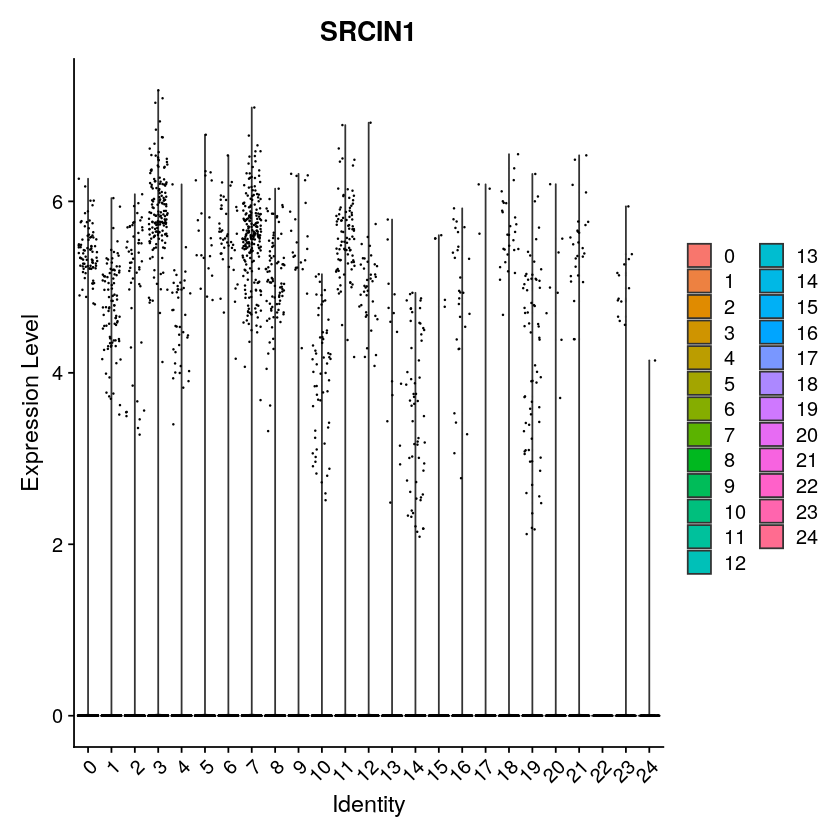

In [21]:
VlnPlot(sc_data, features = "SRCIN1", group.by = "seurat_clusters")

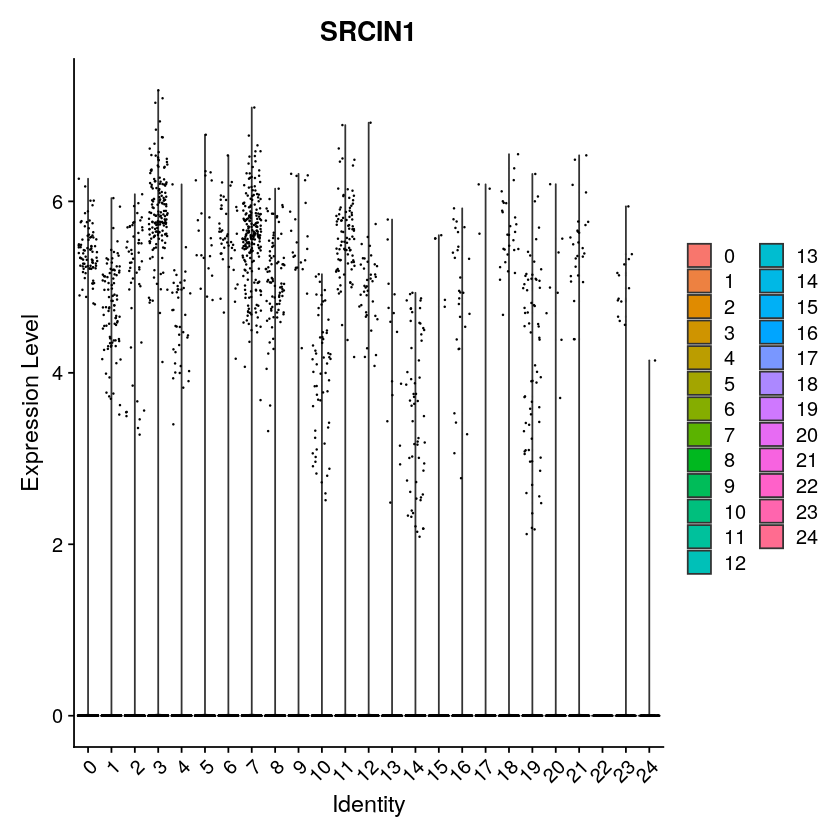

In [22]:
p <- VlnPlot(sc_data, features = "SRCIN1")
print(p)

In [23]:
"SRCIN1" %in% rownames(sc_data)

[1] TRUE

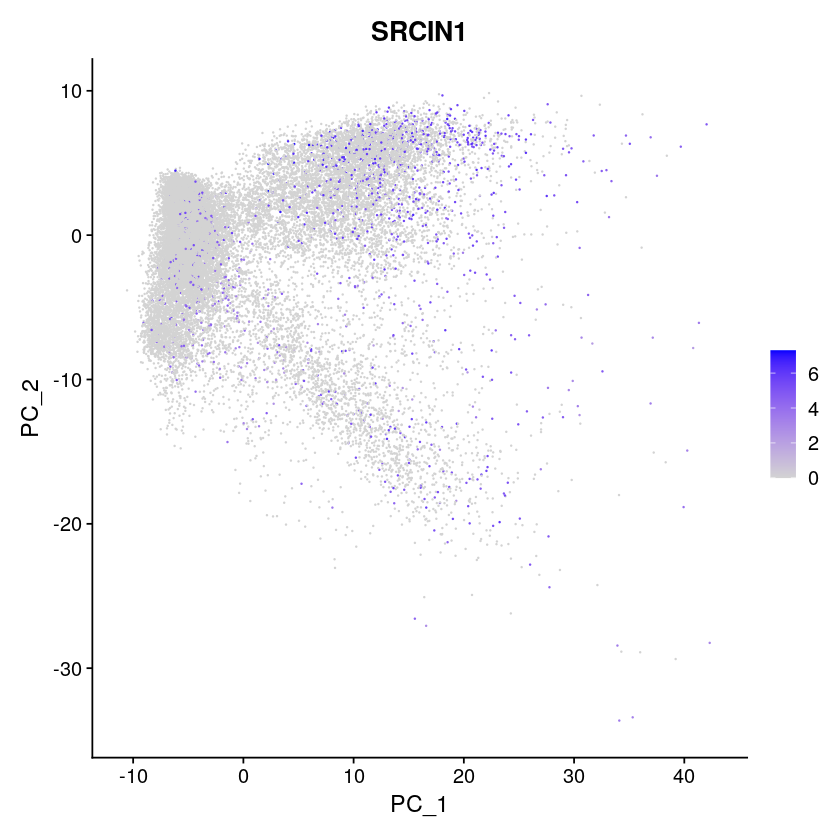

In [24]:
FeaturePlot(sc_data, features = "SRCIN1")

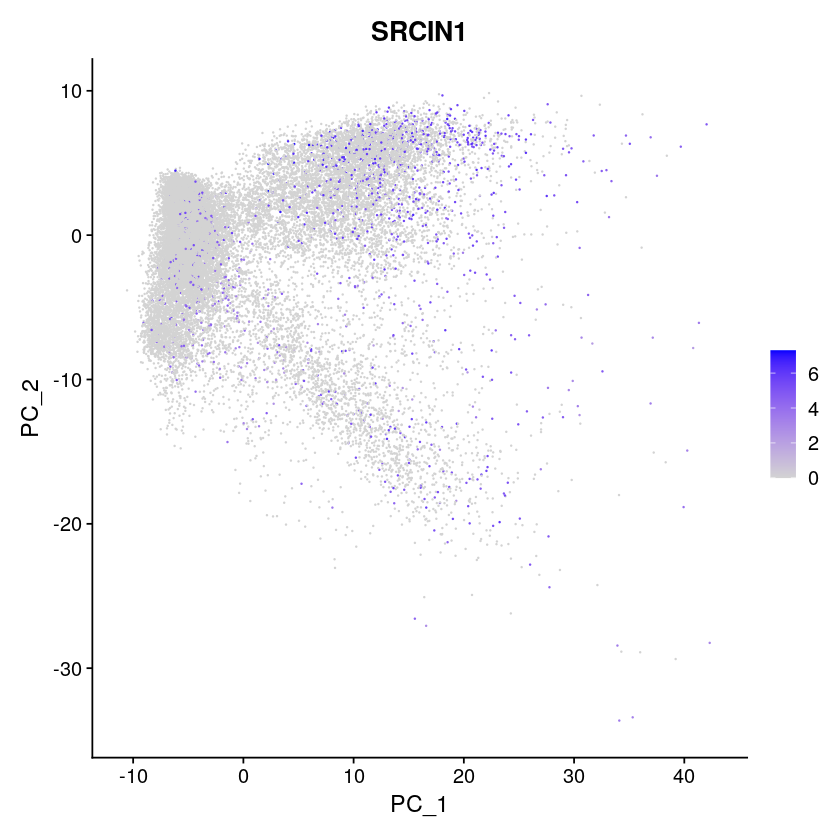

In [25]:
fp <- FeaturePlot(sc_data, features = "SRCIN1")
print(fp)

In [26]:
ggsave("vlnplot.png", plot = VlnPlot(sc_data, features = "SRCIN1"))

Saving 6.67 x 6.67 in image


In [22]:
packageVersion("Seurat")
packageVersion("ggplot2")
packageVersion("patchwork")

[1] ‘4.3.0’

[1] ‘3.5.2’

[1] ‘1.1.2’

In [107]:
#install.package("patchwork")
# Downgrade ggplot2 if needed:
remotes::install_version("ggplot2", version = "3.4.4")

viridisLite (0.4.1 -> 0.4.2) [CRAN]
labeling    (0.4.2 -> 0.4.3) [CRAN]
farver      (2.1.1 -> 2.1.2) [CRAN]
gtable      (0.3.1 -> 0.3.6) [CRAN]


Installing 4 packages: viridisLite, labeling, farver, gtable

Installing packages into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



In [27]:
packageVersion("Seurat")
packageVersion("ggplot2")
packageVersion("patchwork")

[1] ‘5.0.0’

[1] ‘3.4.4’

[1] ‘1.1.3’

In [28]:
sessionInfo()

R version 4.2.0 (2022-04-22)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: Ubuntu 20.04.6 LTS

Matrix products: default
BLAS:   /usr/lib/x86_64-linux-gnu/openblas-pthread/libblas.so.3
LAPACK: /usr/lib/x86_64-linux-gnu/openblas-pthread/liblapack.so.3

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
 [1] openai_0.4.1       GPTCelltype_1.0.1  enrichR_3.4        cowplot_1.1.1     
 [5] presto_1.0.0       data.table_1.17.4  Rcpp_1.0.14        future_1.33.0     
 [9] lubridate_1.9.4    forcats_1.0.0      stringr_1.5.1      dplyr_1.1.4       
[13] purrr_

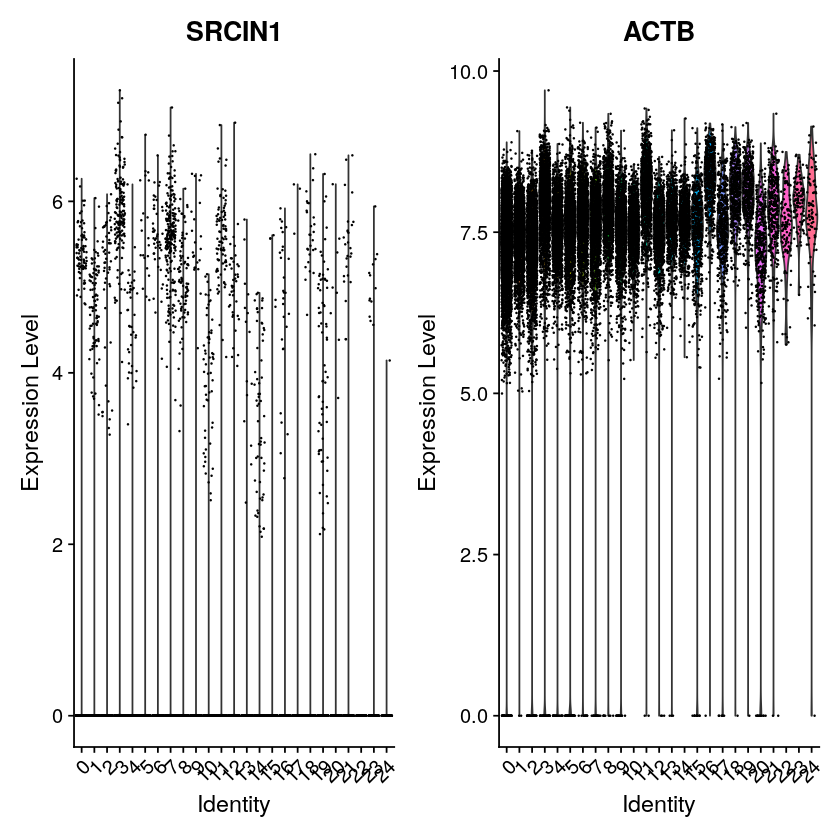

In [29]:
# Plot the expression levels of SRCIN1 and Actin across the clusters
violin <- VlnPlot(sc_data, features = genes_of_interest, group.by = "seurat_clusters", layer = "data")
print(violin)

## other

In [67]:
for (time_point in 1:8) {
    # Load the data
    sc_data <- load.data(time_point)

    # Run PCA and clustering
    sc_data <- PCA.cluster(sc_data, res = 1)
    
    # Find all markers
    cluster_markers <- cluster.markers(sc_data)
    
    # Find differentially expressed genes
    de_genes <- de.genes(genes_of_interest)
}

[1] "Loading data for time point: 23days"


Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "Running PCA and clustering for time point: 23days"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 29736
Number of edges: 1146654

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8914
Number of communities: 25
Elapsed time: 6 seconds

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
5195 2314 2018 2001 1731 1659 1558 1476 1446 1341 1213 1185 1021  914  872  585 
  16   17   18   19   20   21   22   23   24 
 578  545  526  488  401  362  116  106   85 
[1] "Finding all markers for time point: 23days"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24



[1] "Finding differentially expressed genes for time point: 23days"
    p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene
CIT     0   3.193657 0.291 0.025         0      10  CIT
[1] "Loading data for time point: 1month"


Warning message:
“Input parameters result in NA values for initial cell identities. Setting all initial idents to the project name”
Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "Running PCA and clustering for time point: 1month"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 71372
Number of edges: 2685108

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9116
Number of communities: 42
Elapsed time: 18 seconds


2 singletons identified. 40 final clusters.




   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
7162 5595 4269 4126 3764 3613 3064 3040 2673 2397 2218 2123 2043 2042 1935 1919 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
1730 1617 1583 1439 1285 1267 1231 1158 1084 1007  774  739  669  579  522  483 
  32   33   34   35   36   37   38   39 
 403  358  346  296  251  222  195  151 
[1] "Finding all markers for time point: 1month"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 32

Calculating cluster 33

Calculating cluster 34

Calculating cluster 35

Calculating cluster 36

Calculating cluster 37

Calculating cluster 38

Calculating cluster 39



[1] "Finding differentially expressed genes for time point: 1month"
                  p_val avg_log2FC pct.1 pct.2     p_val_adj cluster     gene
CIT        0.000000e+00  3.0578819 0.499 0.050  0.000000e+00      10      CIT
KIAA1217  5.057354e-295  1.4059139 0.298 0.074 1.287349e-290      10 KIAA1217
KIAA12171  0.000000e+00  1.8559716 0.312 0.074  0.000000e+00      12 KIAA1217
SRCIN1    2.218181e-287  1.9409597 0.288 0.069 5.646380e-283      14   SRCIN1
SRCIN11   4.036044e-218  2.3014914 0.272 0.070 1.027375e-213      17   SRCIN1
SRCIN12   2.791548e-237  2.1693878 0.318 0.071 7.105884e-233      22   SRCIN1
CIT1      1.750343e-100  1.8544184 0.256 0.062  4.455497e-96      27      CIT
KIAA12172  0.000000e+00  1.3831897 0.590 0.077  0.000000e+00      30 KIAA1217
CIT2      1.284798e-166  0.8506545 0.377 0.062 3.270452e-162      30      CIT
SRCIN13    8.939078e-44  0.8892115 0.301 0.074  2.275442e-39      35   SRCIN1
[1] "Loading data for time point: 1.5month"


Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "Running PCA and clustering for time point: 1.5month"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 38574
Number of edges: 1423897

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8644
Number of communities: 22
Elapsed time: 10 seconds

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
6027 3309 3182 3140 2870 2405 2359 2253 2064 1626 1417 1364 1222 1155 1024  998 
  16   17   18   19   20   21 
 784  642  517  133   54   29 
[1] "Finding all markers for time point: 1.5month"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21



[1] "Finding differentially expressed genes for time point: 1.5month"
                 p_val avg_log2FC pct.1 pct.2     p_val_adj cluster     gene
CIT       0.000000e+00   3.395686 0.363 0.031  0.000000e+00       9      CIT
KIAA1217 3.513031e-121   1.022686 0.260 0.081 8.448487e-117       9 KIAA1217
[1] "Loading data for time point: 2month"


Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "Running PCA and clustering for time point: 2month"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 39299
Number of edges: 1569367

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8836
Number of communities: 23
Elapsed time: 8 seconds

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3858 3722 3368 2943 2866 2568 2146 2141 1651 1647 1396 1354 1261 1190 1155 1141 
  16   17   18   19   20   21   22 
1099  933  896  644  602  466  252 
[1] "Finding all markers for time point: 2month"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22



[1] "Finding differentially expressed genes for time point: 2month"
    p_val avg_log2FC pct.1 pct.2 p_val_adj cluster gene
CIT     0   3.579014  0.29 0.019         0      21  CIT
[1] "Loading data for time point: 3month"


Warning message:
“Input parameters result in NA values for initial cell identities. Setting all initial idents to the project name”
Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "Running PCA and clustering for time point: 3month"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 159533
Number of edges: 5213586

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8953
Number of communities: 35
Elapsed time: 66 seconds

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
9375 8465 8252 8244 7853 7389 7315 7017 6928 6673 6532 5708 5592 5015 4810 4751 
  16   17   18   19   20   21   22   23   24   25   26   27   28   29   30   31 
4735 4628 4597 4267 4098 3815 3673 3561 3384 2726 2564 2198 1822  806  677  620 
  32   33   34 
 556  450  437 
[1] "Finding all markers for time point: 3month"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 32

Calculating cluster 33

Calculating cluster 34



[1] "Finding differentially expressed genes for time point: 3month"
                p_val avg_log2FC pct.1 pct.2     p_val_adj cluster   gene
SRCIN1  4.995916e-286  0.9200953 0.261 0.128 1.358689e-281       0 SRCIN1
SRCIN11  0.000000e+00  1.1170568 0.381 0.128  0.000000e+00      15 SRCIN1
CIT      0.000000e+00  5.0454299 0.262 0.008  0.000000e+00      21    CIT
SRCIN12 1.154626e-161  0.6847937 0.300 0.132 3.140120e-157      22 SRCIN1
[1] "Loading data for time point: 4month"


Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "Running PCA and clustering for time point: 4month"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 38348
Number of edges: 1433556

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8553
Number of communities: 24
Elapsed time: 8 seconds


1 singletons identified. 23 final clusters.




   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
3654 3231 3149 2453 2450 2395 2382 2222 2170 2073 1813 1801 1753 1522 1276 1096 
  16   17   18   19   20   21   22 
 889  738  596  292  276   67   50 
[1] "Finding all markers for time point: 4month"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22



[1] "Finding differentially expressed genes for time point: 4month"
                p_val avg_log2FC pct.1 pct.2    p_val_adj cluster     gene
SRCIN1   2.412781e-68  0.2853202 0.313 0.156 5.862334e-64       3   SRCIN1
SRCIN11  6.633565e-59  0.3596337 0.324 0.158 1.611757e-54      10   SRCIN1
CIT      0.000000e+00  4.1216672 0.252 0.011 0.000000e+00      15      CIT
CIT1     0.000000e+00  4.4161824 0.317 0.012 0.000000e+00      17      CIT
KIAA1217 3.103031e-98  4.2831081 0.260 0.007 7.539434e-94      22 KIAA1217
[1] "Loading data for time point: 5month"


Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "Running PCA and clustering for time point: 5month"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 31787
Number of edges: 1226270

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8775
Number of communities: 28
Elapsed time: 6 seconds

   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
2631 2568 1907 1845 1821 1595 1548 1532 1522 1489 1295 1220 1059  988  933  920 
  16   17   18   19   20   21   22   23   24   25   26   27 
 860  847  825  818  780  757  485  445  367  301  243  186 
[1] "Finding all markers for time point: 5month"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27



[1] "Finding differentially expressed genes for time point: 5month"
               p_val avg_log2FC pct.1 pct.2    p_val_adj cluster   gene
SRCIN1  4.165019e-65  0.7577704 0.339 0.179 1.020388e-60       2 SRCIN1
SRCIN11 1.860665e-17  0.6270709 0.272 0.184 4.558444e-13       7 SRCIN1
SRCIN12 9.039536e-34  0.7906775 0.297 0.183 2.214596e-29       8 SRCIN1
SRCIN13 3.705076e-36  0.7583852 0.306 0.183 9.077065e-32       9 SRCIN1
SRCIN14 1.506956e-08  0.5294067 0.256 0.187 3.691892e-04      14 SRCIN1
CIT     0.000000e+00  4.0456348 0.413 0.022 0.000000e+00      16    CIT
SRCIN15 1.363851e-10  0.2839111 0.315 0.187 3.341299e-06      22 SRCIN1
SRCIN16 5.460312e-16  0.2993655 0.468 0.187 1.337722e-11      27 SRCIN1
[1] "Loading data for time point: 6month"


Warning message:
“Input parameters result in NA values for initial cell identities. Setting all initial idents to the project name”
Normalizing layer: counts

Finding variable features for layer data

Centering and scaling data matrix



[1] "Running PCA and clustering for time point: 6month"


Computing nearest neighbor graph

Computing SNN



Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 123765
Number of edges: 4127244

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8981
Number of communities: 33
Elapsed time: 42 seconds

    0     1     2     3     4     5     6     7     8     9    10    11    12 
10998 10702  9669  7258  6548  6121  6007  5257  4971  4968  4336  4171  4034 
   13    14    15    16    17    18    19    20    21    22    23    24    25 
 3948  3688  3611  3253  3235  3216  2454  2172  1956  1845  1797  1552  1291 
   26    27    28    29    30    31    32 
 1158   821   800   677   609   525   117 
[1] "Finding all markers for time point: 6month"


Calculating cluster 0

Calculating cluster 1

Calculating cluster 2

Calculating cluster 3

Calculating cluster 4

Calculating cluster 5

Calculating cluster 6

Calculating cluster 7

Calculating cluster 8

Calculating cluster 9

Calculating cluster 10

Calculating cluster 11

Calculating cluster 12

Calculating cluster 13

Calculating cluster 14

Calculating cluster 15

Calculating cluster 16

Calculating cluster 17

Calculating cluster 18

Calculating cluster 19

Calculating cluster 20

Calculating cluster 21

Calculating cluster 22

Calculating cluster 23

Calculating cluster 24

Calculating cluster 25

Calculating cluster 26

Calculating cluster 27

Calculating cluster 28

Calculating cluster 29

Calculating cluster 30

Calculating cluster 31

Calculating cluster 32



[1] "Finding differentially expressed genes for time point: 6month"
                p_val avg_log2FC pct.1 pct.2     p_val_adj cluster   gene
SRCIN1   2.278055e-80  0.4779396 0.261 0.074  5.959165e-76      27 SRCIN1
SRCIN11 3.216065e-113  1.3244443 0.345 0.074 8.412904e-109      31 SRCIN1


In [34]:
# Plotting
plotting <- function(sc_data, genes_oi){
  # Plot the expression of the genes of interest
  for (gene in genes_oi) {
    p1 <- FeaturePlot(sc_data, features = gene, cols = c("lightgrey", "blue"), pt.size = 0.5) + 
      ggtitle(paste("Expression of", gene)) + 
      theme_minimal()
    
    # Save the plot
    ggsave(filename = paste(name_new_dir_partial, "/FeaturePlot_", gene, "_", timepoints[time_point], ".png", sep=""), plot = p1)
  }
}

In [35]:
plotting(sc_data, housekeeping_genes)
# Plot the expression of the genes of interest
plotting(sc_data, genes_of_interest)
# Plot the expression of the housekeeping genes and genes of interest together
plotting(sc_data, c(housekeeping_genes, genes_of_interest))

Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image
Saving 7 x 7 in image


In [12]:
sc_data <- load.clusters(1,1)
cluster_markers <- load.markers(1)

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”


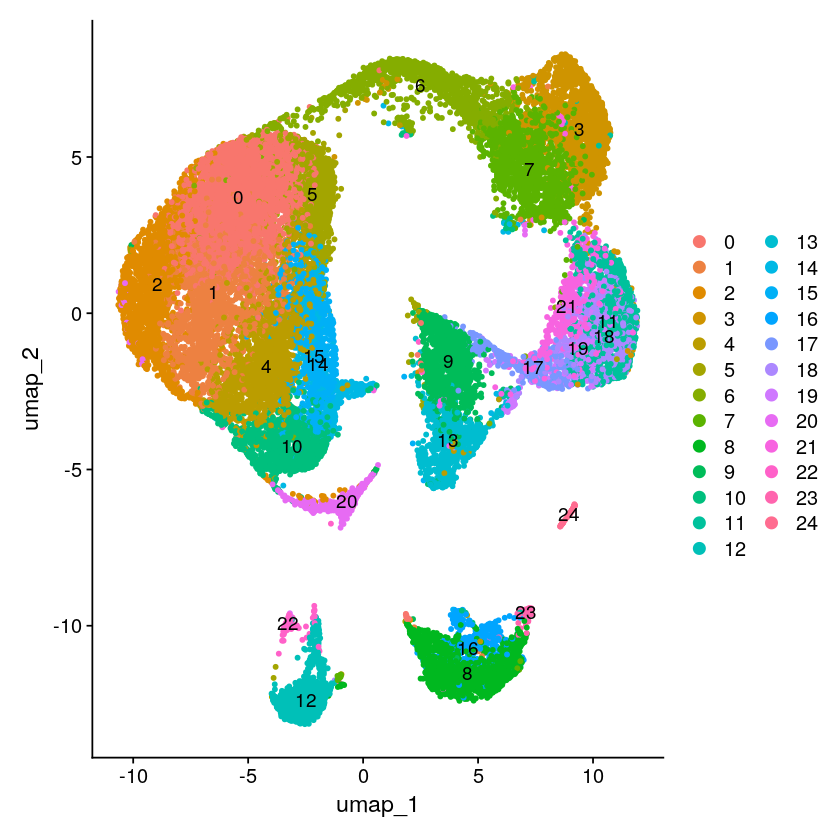

In [30]:
sc_UMAP <- suppressMessages(RunUMAP(sc_data, dims = 1:10))
DimPlot(sc_UMAP, reduction = "umap", label = TRUE, pt.size = 1)